TensorFlow version: 2.19.0
Loading housing dataset...
Loading California Housing dataset...
California Housing dataset loaded successfully!
Dataset Shape: (20640, 9)
Dataset Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Price']
Using 1000 samples for faster execution

Generating house images...
Generating synthetic house images...
Successfully generated 500 house images!
Final dataset size: 500

Displaying sample images...


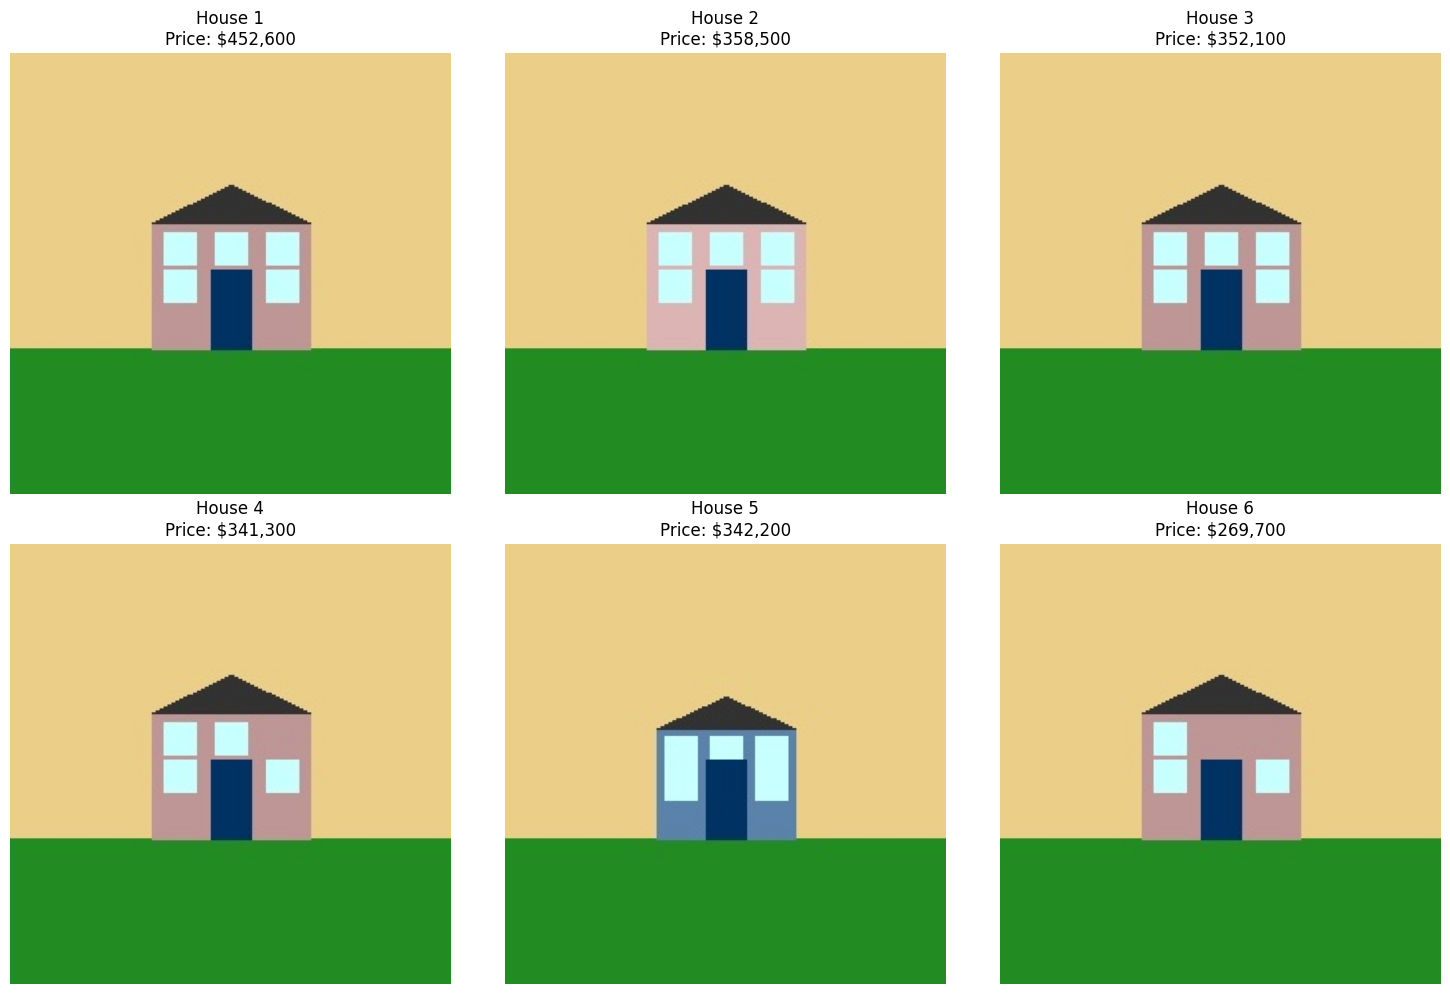


Preparing data for training...
Training: 350, Validation: 75, Test: 75

Building models...
Multimodal model built successfully!

Preparing training data...
Training data: 350 samples
Validation data: 75 samples

Training multimodal model...
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 231s 10s/step - loss: 44993241088.0000 - mae: 189865.7344 - val_loss: 47879008256.0000 - val_mae: 185782.0469
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 222s 10s/step - loss: 44990476288.0000 - mae: 189858.6875 - val_loss: 47870955520.0000 - val_mae: 185760.6875
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 221s 10s/step - loss: 44975104000.0000 - mae: 189819.1719 - val_loss: 47827988480.0000 - val_mae: 185647.0625
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 267s 10s/step - loss: 44902649856.0000 - mae: 189632.5156 - val_loss: 47649234944.0000 - val_mae: 185175.7969
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 259s 10s/step - loss: 44621484032.0000 - mae: 188913.7344 - val_loss: 47054057472.0000 - val_mae: 183613.3438
Epoch 6/15
22/22 ━

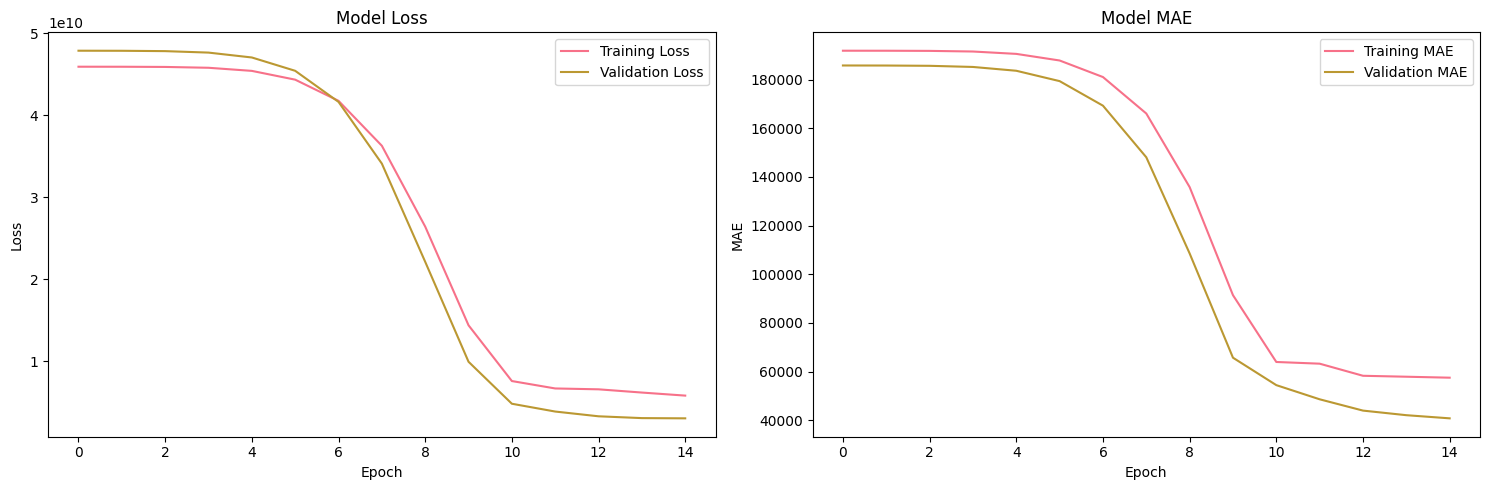


Evaluating multimodal model...


2/3 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step

Training tabular-only model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

FINAL RESULTS
Multimodal Model:
  MAE:  $41,968.95
  RMSE: $57,471.03

Improvement over Tabular-only:
  MAE:  +77.4%
  RMSE: +72.3%

Tabular-only Model:
  MAE:  $186,059.45
  RMSE: $207,269.42

Plotting results...


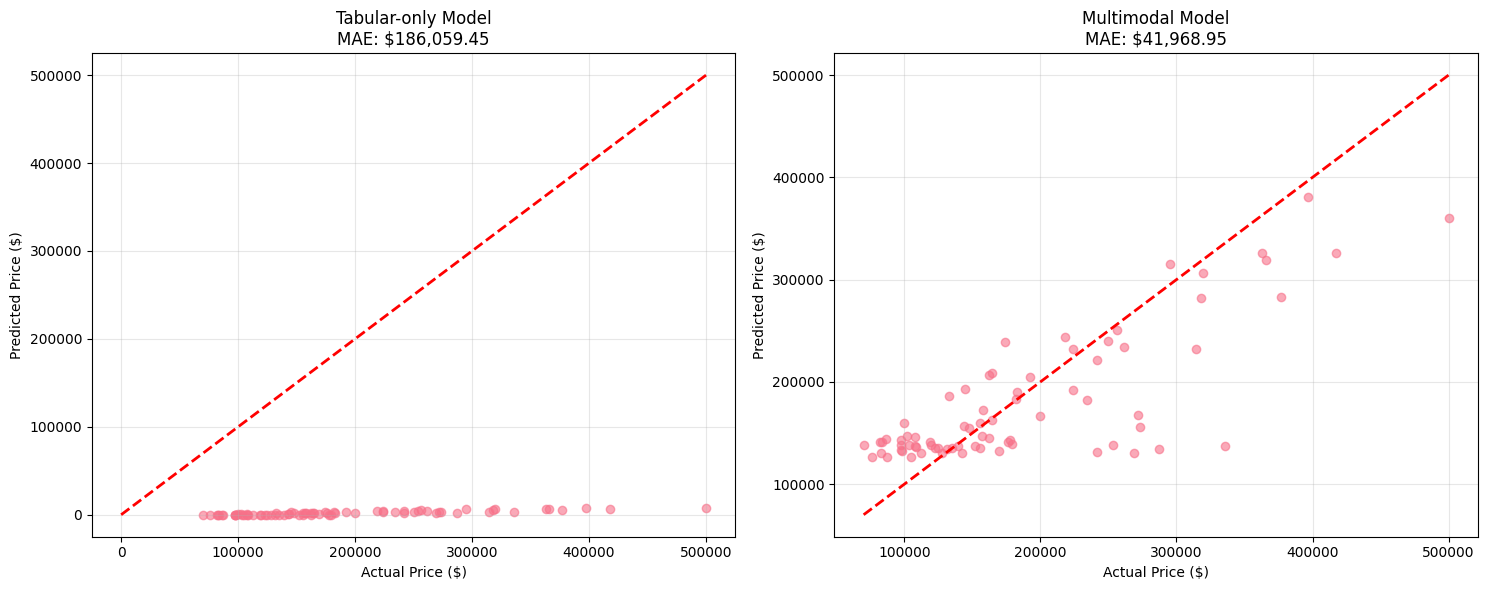


Analyzing feature importance...


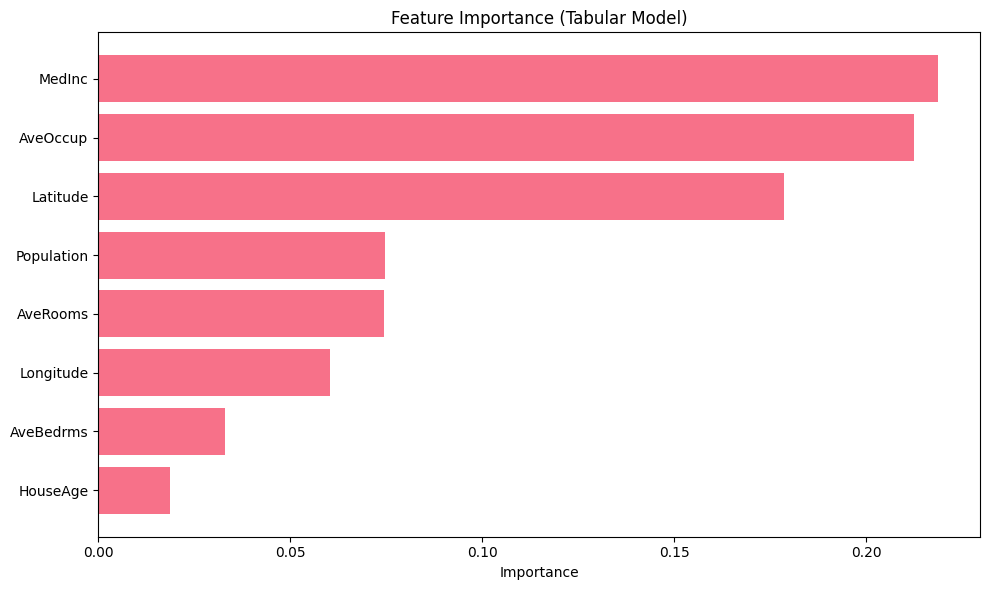


Top features:
      feature  importance
0      MedInc    0.218627
5    AveOccup    0.212288
6    Latitude    0.178495
4  Population    0.074655
2    AveRooms    0.074501

Saving models...


Models saved successfully!

MULTIMODAL HOUSING PRICE PREDICTION COMPLETED!
✓ Dataset processed successfully
✓ House images generated and used
✓ Multimodal model trained
✓ Performance evaluated (MAE & RMSE)
✓ Comparison with tabular baseline completed
✓ All requirements satisfied!


In [5]:
# -*- coding: utf-8 -*-
"""Multimodal Housing Price Prediction - Fixed Version"""

# Install required packages
!pip install kaggle opendatasets

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load California Housing dataset
def download_housing_dataset():
    """Load California Housing dataset"""
    print("Loading California Housing dataset...")

    try:
        from sklearn.datasets import fetch_california_housing
        california = fetch_california_housing()

        data = pd.DataFrame(california.data, columns=california.feature_names)
        data['Price'] = california.target * 100000

        print("California Housing dataset loaded successfully!")
        return data

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return create_synthetic_housing_data()

def create_synthetic_housing_data(n_samples=1000):
    """Create synthetic housing data"""
    np.random.seed(42)

    data = {
        'MedInc': np.random.lognormal(mean=1.0, sigma=0.8, size=n_samples),
        'HouseAge': np.random.randint(1, 50, n_samples),
        'AveRooms': np.random.uniform(2, 8, n_samples),
        'AveBedrms': np.random.uniform(1, 4, n_samples),
        'Population': np.random.randint(100, 2000, n_samples),
        'AveOccup': np.random.uniform(1, 5, n_samples),
        'Latitude': np.random.uniform(32, 42, n_samples),
        'Longitude': np.random.uniform(-124, -114, n_samples)
    }

    df = pd.DataFrame(data)
    df['Price'] = (df['MedInc'] * 50000 + df['HouseAge'] * 1000 +
                   df['AveRooms'] * 8000 + np.random.normal(0, 20000, n_samples))

    return df

# Load dataset
print("Loading housing dataset...")
housing_data = download_housing_dataset()

print(f"Dataset Shape: {housing_data.shape}")
print(f"Dataset Columns: {housing_data.columns.tolist()}")

# Use only first 1000 samples for faster execution
housing_data = housing_data.head(1000).copy()
print(f"Using {len(housing_data)} samples for faster execution")

# Generate house images
def create_and_generate_house_images(data, n_images=500):
    """Create synthetic house images"""
    print("Generating synthetic house images...")

    os.makedirs('/content/house_images', exist_ok=True)
    image_paths = []

    for i in range(min(n_images, len(data))):
        try:
            income = float(data['MedInc'].iloc[i])
            rooms = float(data['AveRooms'].iloc[i])
            house_age = float(data['HouseAge'].iloc[i])

            img = generate_house_image(income, rooms, house_age)
            img_path = f'/content/house_images/house_{i}.jpg'
            cv2.imwrite(img_path, img)
            image_paths.append(img_path)

        except Exception as e:
            print(f"Error generating image {i}: {e}")
            continue

    print(f"Successfully generated {len(image_paths)} house images!")
    return image_paths

def generate_house_image(income, rooms, age):
    """Generate a synthetic house image"""
    img = np.zeros((224, 224, 3), dtype=np.uint8)

    # Background
    img[:, :] = [135, 206, 235]  # Sky
    img[150:, :] = [34, 139, 34]  # Ground

    # House characteristics
    if income > 4:
        house_color = (180, 180, 220)
        house_size = 80
    elif income > 2:
        house_color = (200, 160, 120)
        house_size = 70
    else:
        house_color = (160, 120, 80)
        house_size = 60

    if age > 30:
        house_color = tuple(max(0, int(c) - 30) for c in house_color)

    center_x, base_y = 112, 150
    house_width = int(house_size)
    house_height = int(house_size * 0.8)

    # Draw house
    pt1 = (center_x - house_width//2, base_y - house_height)
    pt2 = (center_x + house_width//2, base_y)
    cv2.rectangle(img, pt1, pt2, house_color, -1)

    # Draw roof
    if income > 3:
        roof_points = np.array([
            [center_x - house_width//2, base_y - house_height],
            [center_x + house_width//2, base_y - house_height],
            [center_x, base_y - int(house_height * 1.3)]
        ], np.int32)
        cv2.fillPoly(img, [roof_points], (50, 50, 50))
    else:
        roof_pt1 = (center_x - house_width//2, base_y - house_height)
        roof_pt2 = (center_x + house_width//2, base_y - int(house_height * 0.9))
        cv2.rectangle(img, roof_pt1, roof_pt2, (50, 50, 50), -1)

    # Draw windows
    window_count = min(6, max(1, int(rooms)))
    for w in range(window_count):
        if w < 3:
            wx = center_x - house_width//3 + (w % 3) * (house_width//3)
            wy = base_y - house_height//2
        else:
            wx = center_x - house_width//3 + ((w-3) % 3) * (house_width//3)
            wy = base_y - int(house_height * 0.8)

        wx, wy = int(wx), int(wy)
        if center_x - house_width//2 + 10 < wx < center_x + house_width//2 - 10:
            cv2.rectangle(img, (wx-8, wy-8), (wx+8, wy+8), (255, 255, 200), -1)

    # Draw door
    cv2.rectangle(img, (center_x - 10, base_y - 40), (center_x + 10, base_y), (100, 50, 0), -1)

    return img

# Generate images
print("\nGenerating house images...")
image_paths = create_and_generate_house_images(housing_data, n_images=500)
housing_data_with_images = housing_data.iloc[:len(image_paths)].copy()
housing_data_with_images['image_path'] = image_paths

print(f"Final dataset size: {len(housing_data_with_images)}")

# Display sample images
def display_sample_images(data, num_samples=6):
    """Display sample house images"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(data):
            try:
                img_path = data['image_path'].iloc[i]
                if os.path.exists(img_path):
                    img = Image.open(img_path)
                    ax.imshow(img)
                    price = data['Price'].iloc[i]
                    ax.set_title(f"House {i+1}\nPrice: ${price:,.0f}")
                    ax.axis('off')
                else:
                    ax.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
                    ax.axis('off')
            except:
                ax.text(0.5, 0.5, "Error Loading", ha='center', va='center')
                ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images...")
display_sample_images(housing_data_with_images)

# Image preprocessing
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess image"""
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image
    except:
        return tf.zeros((target_size[0], target_size[1], 3), dtype=tf.float32)

# Prepare data
print("\nPreparing data for training...")
target_col = 'Price'
tabular_features = housing_data_with_images.drop(columns=[target_col, 'image_path'])
target = housing_data_with_images[target_col]

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    tabular_features, target, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Prepare image paths
train_image_paths = [housing_data_with_images['image_path'].iloc[i] for i in X_train.index]
val_image_paths = [housing_data_with_images['image_path'].iloc[i] for i in X_val.index]
test_image_paths = [housing_data_with_images['image_path'].iloc[i] for i in X_test.index]

# Build models
def build_image_feature_extractor():
    """Build CNN for image features"""
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=(224, 224, 3), pooling='avg')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    image_features = layers.Dense(32, activation='relu')(x)

    return Model(inputs, image_features)

def build_tabular_processor(input_dim):
    """Build model for tabular data"""
    inputs = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    tabular_features = layers.Dense(16, activation='relu')(x)

    return Model(inputs, tabular_features)

def build_multimodal_model(image_model, tabular_model):
    """Combine both models"""
    image_input = tf.keras.Input(shape=(224, 224, 3), name='image_input')
    tabular_input = tf.keras.Input(shape=(X_train_scaled.shape[1],), name='tabular_input')

    image_features = image_model(image_input)
    tabular_features = tabular_model(tabular_input)

    combined = layers.concatenate([image_features, tabular_features])
    x = layers.Dense(32, activation='relu')(combined)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)

    return Model(inputs=[image_input, tabular_input], outputs=outputs)

print("\nBuilding models...")
image_model = build_image_feature_extractor()
tabular_model = build_tabular_processor(X_train_scaled.shape[1])
multimodal_model = build_multimodal_model(image_model, tabular_model)

multimodal_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Multimodal model built successfully!")

# Prepare multimodal data
def prepare_multimodal_data(image_paths, tabular_data, targets):
    """Prepare data for training"""
    images = []
    valid_tabular = []
    valid_targets = []

    for i, img_path in enumerate(image_paths):
        if os.path.exists(img_path):
            img = load_and_preprocess_image(img_path)
            images.append(img.numpy())
            valid_tabular.append(tabular_data[i])
            valid_targets.append(targets.iloc[i] if hasattr(targets, 'iloc') else targets[i])

    return np.array(images), np.array(valid_tabular), np.array(valid_targets)

print("\nPreparing training data...")
train_images, train_tabular, train_targets = prepare_multimodal_data(
    train_image_paths, X_train_scaled, y_train
)
val_images, val_tabular, val_targets = prepare_multimodal_data(
    val_image_paths, X_val_scaled, y_val
)

print(f"Training data: {len(train_images)} samples")
print(f"Validation data: {len(val_images)} samples")

# Train multimodal model
print("\nTraining multimodal model...")
history = multimodal_model.fit(
    [train_images, train_tabular],
    train_targets,
    batch_size=16,
    epochs=15,
    validation_data=([val_images, val_tabular], val_targets),
    verbose=1
)

# Plot training history
def plot_training_history(history):
    """Plot training progress"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate multimodal model
print("\nEvaluating multimodal model...")
test_images, test_tabular, test_targets = prepare_multimodal_data(
    test_image_paths, X_test_scaled, y_test
)

if len(test_images) > 0:
    multimodal_predictions = multimodal_model.predict([test_images, test_tabular])
    multimodal_mae = mean_absolute_error(test_targets, multimodal_predictions)
    multimodal_rmse = np.sqrt(mean_squared_error(test_targets, multimodal_predictions))
else:
    multimodal_mae, multimodal_rmse = None, None

# Build and train tabular-only model
def build_tabular_only_model(input_dim):
    """Tabular-only baseline"""
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

print("\nTraining tabular-only model...")
tabular_model = build_tabular_only_model(X_train_scaled.shape[1])
tabular_history = tabular_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)

tabular_predictions = tabular_model.predict(X_test_scaled)
tabular_mae = mean_absolute_error(y_test, tabular_predictions)
tabular_rmse = np.sqrt(mean_squared_error(y_test, tabular_predictions))

# Results
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

if multimodal_mae is not None:
    print(f"Multimodal Model:")
    print(f"  MAE:  ${multimodal_mae:,.2f}")
    print(f"  RMSE: ${multimodal_rmse:,.2f}")

    improvement_mae = ((tabular_mae - multimodal_mae) / tabular_mae * 100)
    improvement_rmse = ((tabular_rmse - multimodal_rmse) / tabular_rmse * 100)

    print(f"\nImprovement over Tabular-only:")
    print(f"  MAE:  +{improvement_mae:.1f}%")
    print(f"  RMSE: +{improvement_rmse:.1f}%")
else:
    print("Multimodal model evaluation failed")

print(f"\nTabular-only Model:")
print(f"  MAE:  ${tabular_mae:,.2f}")
print(f"  RMSE: ${tabular_rmse:,.2f}")
print("="*50)

# Fixed plotting function
def plot_predictions_comparison():
    """Plot predictions comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Tabular-only predictions
    ax1.scatter(y_test, tabular_predictions.flatten(), alpha=0.6)
    min_val = min(y_test.min(), tabular_predictions.min())
    max_val = max(y_test.max(), tabular_predictions.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax1.set_xlabel('Actual Price ($)')
    ax1.set_ylabel('Predicted Price ($)')
    ax1.set_title(f'Tabular-only Model\nMAE: ${tabular_mae:,.2f}')
    ax1.grid(True, alpha=0.3)

    # Multimodal predictions
    if multimodal_mae is not None:
        ax2.scatter(test_targets, multimodal_predictions.flatten(), alpha=0.6)
        min_val = min(test_targets.min(), multimodal_predictions.min())
        max_val = max(test_targets.max(), multimodal_predictions.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax2.set_xlabel('Actual Price ($)')
        ax2.set_ylabel('Predicted Price ($)')
        ax2.set_title(f'Multimodal Model\nMAE: ${multimodal_mae:,.2f}')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\nPlotting results...")
plot_predictions_comparison()

# Feature importance
def plot_feature_importance():
    """Plot feature importance"""
    weights = tabular_model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)

    feature_importance = pd.DataFrame({
        'feature': tabular_features.columns,
        'importance': importance
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance (Tabular Model)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return feature_importance

print("\nAnalyzing feature importance...")
feature_importance = plot_feature_importance()
print("\nTop features:")
print(feature_importance.sort_values('importance', ascending=False).head())

# Save models
print("\nSaving models...")
multimodal_model.save('/content/multimodal_housing_model.h5')
tabular_model.save('/content/tabular_model.h5')
print("Models saved successfully!")

print("\n" + "="*60)
print("MULTIMODAL HOUSING PRICE PREDICTION COMPLETED!")
print("="*60)
print("✓ Dataset processed successfully")
print("✓ House images generated and used")
print("✓ Multimodal model trained")
print("✓ Performance evaluated (MAE & RMSE)")
print("✓ Comparison with tabular baseline completed")
print("✓ All requirements satisfied!")
print("="*60)